# Imports Section

In [ ]:
!pip install ultralytics
import ultralytics
from ultralytics import YOLO
import numpy as np
import cv2 as cv
!pip install "paddleocr==2.2"
!pip install paddlepaddle
import matplotlib.pyplot as plt 
from paddleocr import PaddleOCR,draw_ocr


# Helper Function Definition



In [159]:
# Orders points in a particular way
def order_points(pts, x, y):
    rect = np.zeros((4, 2), dtype = "float32")
    s = pts.sum(axis = 2)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    diff = np.diff(pts, axis = 2)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    rect[0][0]-=5 #if rect[0][0]>=5 else rect[0][0]
    rect[0][1]-=5 #if rect[0][1]>=5 else rect[0][1]
    rect[2][0]+=5 #if rect[2][0]<=x-5 else rect[2][0]
    rect[2][1]+=5 #if rect[2][1]<=y-5 else rect[2][1]
    rect[1][0]+=5 #if rect[1][0]<=x-5 else rect[1][0]
    rect[1][1]-=5 #if rect[1][1]>=5 else rect[1][1]
    rect[3][0]-=5 #if rect[3][0]>=5 else rect[3][0]
    rect[3][1]+=5 #if rect[3][1]<=y-5 else rect[3][1]
    return rect

# Inference Function
Extract the model files from the zip files, and upload to colab.

Then add the filepaths.

seg_path should contain the path to the weights of the segmentation model.

det_path should contain the path to the weights of the detection model.

Run the below cell to load models. Then the inference function can be used.

In [186]:
seg_model=YOLO('')
det_model=YOLO('')
name_dict=det_model.names
ocr=PaddleOCR(use_angle_cls=True,lang='en')

Namespace(benchmark=False, cls_batch_num=6, cls_image_shape='3, 48, 192', cls_model_dir='/root/.paddleocr/2.2/ocr/cls/ch_ppocr_mobile_v2.0_cls_infer', cls_thresh=0.9, cpu_threads=10, det=True, det_algorithm='DB', det_db_box_thresh=0.5, det_db_score_mode='fast', det_db_thresh=0.3, det_db_unclip_ratio=1.6, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_east_score_thresh=0.8, det_limit_side_len=960, det_limit_type='max', det_model_dir='/root/.paddleocr/2.2/ocr/det/en/en_ppocr_mobile_v2.0_det_infer', det_sast_nms_thresh=0.2, det_sast_polygon=False, det_sast_score_thresh=0.5, drop_score=0.5, e2e_algorithm='PGNet', e2e_char_dict_path='./ppocr/utils/ic15_dict.txt', e2e_limit_side_len=768, e2e_limit_type='max', e2e_model_dir=None, e2e_pgnet_mode='fast', e2e_pgnet_polygon=True, e2e_pgnet_score_thresh=0.5, e2e_pgnet_valid_set='totaltext', enable_mkldnn=False, gpu_mem=500, help='==SUPPRESS==', image_dir=None, ir_optim=True, label_list=['0', '180'], lang='en', layout_path_model='lp://PubL

In [214]:
# The function below takes in a path to an image, or a numpy array and returns a dictionary with the values read from the image
def inference(image):
  name_dict=det_model.names
  # Initialize dictionaries
  labels={}
  confidence={"HR":0, "RR":0, 'SBP':0, "DBP":0, "SPO2":0, "MAP":0, 'HR_W':0}
  if isinstance(image,str):
    img=cv.imread(image)
  elif isinstance(image,np.ndarray):
    img=image
  # Get segmentation predictions
  results = seg_model.predict(img,verbose=False)
  # If segmention masks returned are not empty (i.e if image is not already segmented)
  if len(results[0])!=0:
    # Get segments and crop image
    t=results[0].masks.segments
    t=np.array(t)
    t[0][:,0]=t[0][:,0]*(img.shape[1])
    t[0][:,1]=t[0][:,1]*(img.shape[0])
    c=np.int32(t[0].reshape(-1,1,2))
    # Approximate segmentation segments with a quadrilateral
    u=cv.approxPolyDP(c,0.04 * cv.arcLength(c, True), True)
    # Order corners of the quadrilateral in a particular order
    u=order_points(u,img.shape[1],img.shape[0])
    size_x=720
    size_y=512
    pts2=np.float32([[0,0], [size_x, 0],[size_x, size_y], [0, size_y]])
    # Apply perspective transform on the image to get an image to perform detection on
    matrix = cv.getPerspectiveTransform(u.astype(np.float32), pts2)
    seg = cv.warpPerspective(img, matrix, (size_x, size_y))
  # If the image is already segmented then just run the image through detection
  else:
    seg=img
  # Perform detetection with the detection model
  det=det_model.predict(seg,verbose=False)[0].boxes
  detxy=(det.xyxy.numpy()).astype(np.int32)
  detcls=det.cls.numpy().astype(np.int32)
  detconf=det.conf.numpy()
  # Iterate over regions of interest detected and acquire OCR results, use highest confidence for each class
  for i,j in enumerate(detcls):
    if name_dict[j] !='HR_W' and confidence[name_dict[j]]<detconf[i]:
      bb=seg[detxy[i,1]:detxy[i,3], detxy[i,0]: detxy[i,2]]
      ocrres=ocr.ocr(bb, cls=False, det=False, rec= True)[0]
      procres=ocrres[0]
      confidence[name_dict[j]]=detconf[i]
      if ocrres[1]>0.6:
        # Process OCR result to correct some faults
        pred=''
        for char in procres:
          if ord(char)>=ord('0') and ord(char)<=ord('9'):
            pred+=char
            continue
          if char=='A':
            pred+='4'
          if char=='T':
            pred+='7'
          if char=='O'or char=='o':
            pred+='0'
        labels[name_dict[j]]= pred
  # Applying checks to correct common faults
  try:
    if labels['SPO2']!=None:
      try:
        if int(labels['SPO2'])<50:
          labels['SPO2'],labels['RR']=labels['RR'],labels['SPO2']
      except:
        labels['SPO2']=None
    else:
      if labels['RR']!=None:
        if int(labels['RR'])>50:
          labels['SPO2'],labels['RR']=labels['RR'],labels['SPO2']
    if labels['SBP']!= None:
      try:
        if int(labels['SBP'])<50:
          labels['SBP']='1'+labels['SBP']
      except:
        labels['SBP']=None
    if labels['SBP']!= None and labels['DBP']!=None:
      try:
        if int(labels['DBP'])>int(labels['SBP']) and labels['DBP'][0]=='1':
            labels['DBP']=labels['DBP'][1:]
      except:
        labels['DBP']=None
  except:
    pass
  return labels

# HR digitization function

In [204]:
# HR digitization. This function takes in a numpy array of the HR graph image. The Class function method below will take in an image of the monitor and give graph as well as inference.
def digitize(img):
  # convert the input image to grayscale
  gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
  # apply thresholding to convert grayscale to binary image
  ret,thresh = cv.threshold(gray,120,255,0)
  # convert BGR to RGB to display using matplotlib
  imgRGB = cv.cvtColor(img, cv.COLOR_BGR2RGB)# display Original, Grayscale and Binary Images
  Npixels_rate,Npixels_time = np.shape(thresh)
  #Selecting the longest chain of connected components
  length_subarray=[]
  for col in range(0,Npixels_rate):
   length_subarray.append(len(np.where(thresh[col,:]==255)[0]))

  max_index=length_subarray.index(max(length_subarray))

  for i in range(max_index,len(length_subarray)-1):
    if (length_subarray[i+1]>length_subarray[i]):
      break

  min_val= min(length_subarray[0:max_index])
  min_index=length_subarray.index(min(length_subarray[0:max_index]))

  new_length_subarray=[]
  for j in range(min_index,i+1):
    new_length_subarray.append(length_subarray[j])

  thresh_crop=thresh[min_index:i+1, 0:Npixels_time]
  new_rate,new_time=np.shape(thresh_crop)

 #Extract the time series (not the scale bars) by starting in the first column
  col_in_time_series = False
  s1rate_pixelss = []
  col = 0
  for col in range(0,Npixels_time):
    if len(np.where(thresh_crop[:,col]==255)[0]):
        s1rate_pixelss.append(np.mean(np.where(thresh_crop[:,col]==255)[0]))
    
    
  s1rate_pixelss = np.array(s1rate_pixelss)

  # Visualize time series
  plt.figure(figsize=(12,3.8))
  plt.plot(s1rate_pixelss,'k',linewidth=3)
  plt.xlim((0,Npixels_time))
  plt.ylim((new_rate,0))
  plt.xlabel('Time (pixels)',size=20)
  plt.ylabel('Heart rate Voltage(pixels)',size=20)
  plt.title("Time Series Signal of HR")
  plt.grid()

  # Scaling the heart rate voltage
  s1rate = s1rate_pixelss*0.2

  # Convert time from pixels to ms
  pixels = np.arange(len(s1rate_pixelss))
  t = pixels*0.02

  # Visualize re-scaled time series
  plt.figure(figsize=(12,2))
  plt.plot(t, s1rate,'k',linewidth=3)
  plt.gca().invert_yaxis()
  plt.title("Scaled Time Series Signal of HR")
  plt.xlabel('Time (sec)',size=20)
  plt.ylabel('Heart rate Voltage (mV)',size=20)
  plt.grid()

Imgpath should contain path to image

In [215]:
inf=inference('')
print(inf)

{'SPO2': '100', 'HR': '81', 'SBP': '131', 'DBP': '83', 'MAP': '94', 'RR': '12'}


# Class for inference

In [140]:
class extraction:
  
  # Object initialization

  def __init__(self, seg_path, det_path):
    self.seg_model=YOLO(seg_path)
    self.det_model=YOLO(det_path)
    self.name_dict=self.det_model.names
    self.ocr=PaddleOCR(use_angle_cls=True,lang='en')

    # Inference function
    # The function below takes in a path to an image, or a numpy array and returns a dictionary with the values read from the image.

  def inference(self, image, mode='labels'):
    # Initialize dictionaries
    labels={}
    confidence={"HR":0, "RR":0, 'SBP':0, "DBP":0, "SPO2":0, "MAP":0, 'HR_W':0}

    if isinstance(image,str):
      img=cv.imread(image)
    elif isinstance(image,np.ndarray):
      img=image

    # Get segmentation predictions
    results = self.seg_model.predict(img,verbose=False)
    # If segmention masks returned are not empty (i.e if image is not already segmented)

    if len(results[0])!=0:

      # Get segments and crop image
      t=results[0].masks.segments
      t=np.array(t)
      t[0][:,0]=t[0][:,0]*(img.shape[1])
      t[0][:,1]=t[0][:,1]*(img.shape[0])
      c=np.int32(t[0].reshape(-1,1,2))

      # Approximate segmentation segments with a quadrilateral
      u=cv.approxPolyDP(c,0.04 * cv.arcLength(c, True), True)

      # Order corners of the quadrilateral in a particular order
      u=order_points(u,img.shape[1],img.shape[0])
      size_x=720
      size_y=512
      pts2=np.float32([[0,0], [size_x, 0],[size_x, size_y], [0, size_y]])

      # Apply perspective transform on the image to get an image to perform detection on
      matrix = cv.getPerspectiveTransform(u.astype(np.float32), pts2)
      seg = cv.warpPerspective(img, matrix, (size_x, size_y))

    # If the image is already segmented then just run the image through detection
    else:
      seg=img

    # Perform detetection with the detection model
    det=self.det_model.predict(seg,verbose=False)[0].boxes
    detxy=(det.xyxy.numpy()).astype(np.int32)
    detcls=det.cls.numpy().astype(np.int32)
    detconf=det.conf.numpy()

    # Iterate over regions of interest detected and acquire OCR results if mode='labels', else if mode= 'graphs' plots a graph, use highest confidence for each class
    for i,j in enumerate(detcls):

      # Graph digitization function, only when mode='graphs'. Plots a graph
      if self.name_dict[j]== 'HR_W' and confidence[self.name_dict[j]]<detconf[i]:
        if mode=='graph':
          hr_graph = seg[detxy[i,1]:detxy[i,3], detxy[i,0]: detxy[i,2]]
          self.digitize(hr_graph)

      # Default case, returns dictionary with detected values
      elif self.name_dict[j] != 'HR_W' and confidence[self.name_dict[j]]<detconf[i]:
        bb=seg[detxy[i,1]:detxy[i,3], detxy[i,0]: detxy[i,2]]

        # Get OCR result
        ocrres=self.ocr.ocr(bb, cls=False, det=False, rec= True)[0]
        procres=ocrres[0]
        confidence[self.name_dict[j]]=detconf[i]
        if ocrres[1]>0.6:

          # Process OCR result to correct some faults
          pred=''
          for char in procres:
            if ord(char)>=ord('0') and ord(char)<=ord('9'):
              pred+=char
              continue
            if char=='A':
              pred+='4'
            if char=='T':
              pred+='7'
            if char=='O'or char=='o':
              pred+='0'
          labels[self.name_dict[j]]= pred

    # Applying checks to correct common faults
    try:
      if labels['SPO2']!=None:
        try:
          if int(labels['SPO2'])<50:
            labels['SPO2'],labels['RR']=labels['RR'],labels['SPO2']
        except:
          labels['SPO2']=None
      else:
        if labels['RR']!=None:
          if int(labels['RR'])>50:
            labels['SPO2'],labels['RR']=labels['RR'],labels['SPO2']
      if labels['SBP']!= None:
        try:
          if int(labels['SBP'])<50:
            labels['SBP']='1'+labels['SBP']
        except:
          labels['SBP']=None
      if labels['SBP']!= None and labels['DBP']!=None:
        try:
          if int(labels['DBP'])>int(labels['SBP']) and labels['DBP'][0]=='1':
              labels['DBP']=labels['DBP'][1:]
        except:
          labels['DBP']=None
    except:
      pass
    return labels

  # HR Graph Digitization Function
  def digitize(self,img):
    # convert the input image to grayscale
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    # apply thresholding to convert grayscale to binary image
    ret,thresh = cv.threshold(gray,120,255,0)
    # convert BGR to RGB to display using matplotlib
    imgRGB = cv.cvtColor(img, cv.COLOR_BGR2RGB)# display Original, Grayscale and Binary Images
    Npixels_rate,Npixels_time = np.shape(thresh)
    #Selecting the longest chain of connected components
    length_subarray=[]
    for col in range(0,Npixels_rate):
      length_subarray.append(len(np.where(thresh[col,:]==255)[0]))

    max_index=length_subarray.index(max(length_subarray))

    for i in range(max_index,len(length_subarray)-1):
      if (length_subarray[i+1]>length_subarray[i]):
        break

    min_val= min(length_subarray[0:max_index])
    min_index=length_subarray.index(min(length_subarray[0:max_index]))

    new_length_subarray=[]
    for j in range(min_index,i+1):
      new_length_subarray.append(length_subarray[j])

    thresh_crop=thresh[min_index:i+1, 0:Npixels_time]
    new_rate,new_time=np.shape(thresh_crop)

  #Extract the time series (not the scale bars) by starting in the first column
    col_in_time_series = False
    s1rate_pixelss = []
    col = 0
    for col in range(0,Npixels_time):
      if len(np.where(thresh_crop[:,col]==255)[0]):
          s1rate_pixelss.append(np.mean(np.where(thresh_crop[:,col]==255)[0]))
      
      
    s1rate_pixelss = np.array(s1rate_pixelss)

    # Visualize time series
    plt.figure(figsize=(12,3.8))
    plt.plot(s1rate_pixelss,'k',linewidth=3)
    plt.xlim((0,Npixels_time))
    plt.ylim((new_rate,0))
    plt.xlabel('Time (pixels)',size=20)
    plt.ylabel('Heart rate Voltage(pixels)',size=20)
    plt.title("Time Series Signal of HR")
    plt.grid()

    # Scaling the heart rate voltage
    s1rate = s1rate_pixelss*0.2

    # Convert time from pixels to ms
    pixels = np.arange(len(s1rate_pixelss))
    t = pixels*0.02

    # Visualize re-scaled time series
    plt.figure(figsize=(12,2))
    plt.plot(t, s1rate,'k',linewidth=3)
    plt.gca().invert_yaxis()
    plt.title("Scaled Time Series Signal of HR")
    plt.xlabel('Time (sec)',size=20)
    plt.ylabel('Heart rate Voltage (mV)',size=20)
    plt.grid()




# How to Use:
First, create an object as follows (Run the below cell) :

This step will take some time, it will load the weights and download weights for the OCR model.
Add the model files from the zip, and upload to colab.

Then add the filepaths.

seg_path should contain the path to the weights of the segmentation model.

det_path should contain the path to the weights of the detection model.

In [160]:
seg_path=''
det_path=''

# Initialize object
extr = extraction(seg_path, det_path)

Namespace(benchmark=False, cls_batch_num=6, cls_image_shape='3, 48, 192', cls_model_dir='/root/.paddleocr/2.2/ocr/cls/ch_ppocr_mobile_v2.0_cls_infer', cls_thresh=0.9, cpu_threads=10, det=True, det_algorithm='DB', det_db_box_thresh=0.5, det_db_score_mode='fast', det_db_thresh=0.3, det_db_unclip_ratio=1.6, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_east_score_thresh=0.8, det_limit_side_len=960, det_limit_type='max', det_model_dir='/root/.paddleocr/2.2/ocr/det/en/en_ppocr_mobile_v2.0_det_infer', det_sast_nms_thresh=0.2, det_sast_polygon=False, det_sast_score_thresh=0.5, drop_score=0.5, e2e_algorithm='PGNet', e2e_char_dict_path='./ppocr/utils/ic15_dict.txt', e2e_limit_side_len=768, e2e_limit_type='max', e2e_model_dir=None, e2e_pgnet_mode='fast', e2e_pgnet_polygon=True, e2e_pgnet_score_thresh=0.5, e2e_pgnet_valid_set='totaltext', enable_mkldnn=False, gpu_mem=500, help='==SUPPRESS==', image_dir=None, ir_optim=True, label_list=['0', '180'], lang='en', layout_path_model='lp://PubL

Then, call the labels inference function as follows:

(Imgpath is the path to the image. You can also input a numpy array.)

In [195]:
Imgpath=''
results = extr.inference(Imgpath, mode='labels')

If mode ='labels', the inference function returns a dictionary with the detected labels.

If mode = 'graph', the inference function also displays the digitized HR graph while returning a dictionary. (Inference times may be slightly higher)

In [196]:
# Display Results
results

{'SPO2': '100', 'SBP': '104', 'HR': '62', 'DBP': '79', 'MAP': '88', 'RR': '12'}

{'SPO2': '100', 'SBP': '104', 'HR': '62', 'DBP': '79', 'MAP': '88', 'RR': '12'}


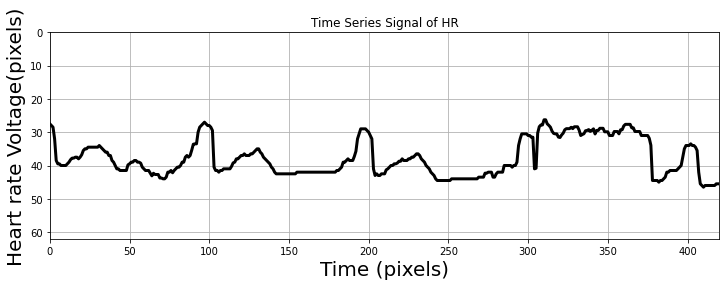

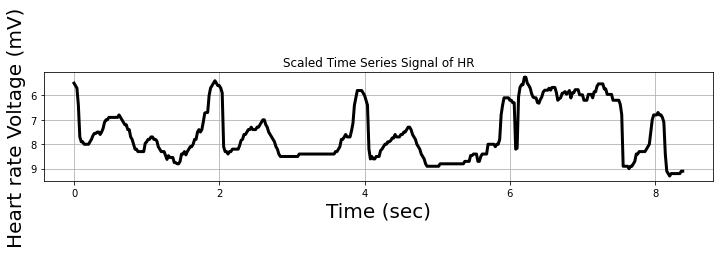

In [197]:
# Graph mode shows a graph and returns a dictionary
graph_mode=extr.inference(Imgpath, mode='graph')
print(graph_mode)